In [82]:
from qiskit import QuantumCircuit, execute, Aer, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit.quantum_info.operators import Operator
from cmath import exp
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit.library import QFT
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

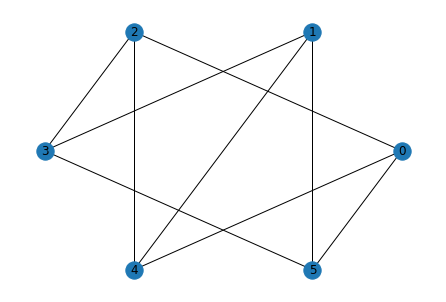

In [83]:
"""Create graph"""
# G = nx.random_regular_graph(3, 6)
# nx.draw_circular(G, with_labels=True)
# print(G.edges)
G = nx.Graph()
G.add_nodes_from([0,1,2,3,4,5])
G.add_edges_from([(2, 4), (2, 3), (2, 0), (4, 0), (4, 1), (0, 5), (1, 5), (1, 3), (5, 3)])
nx.draw_circular(G, with_labels=True)

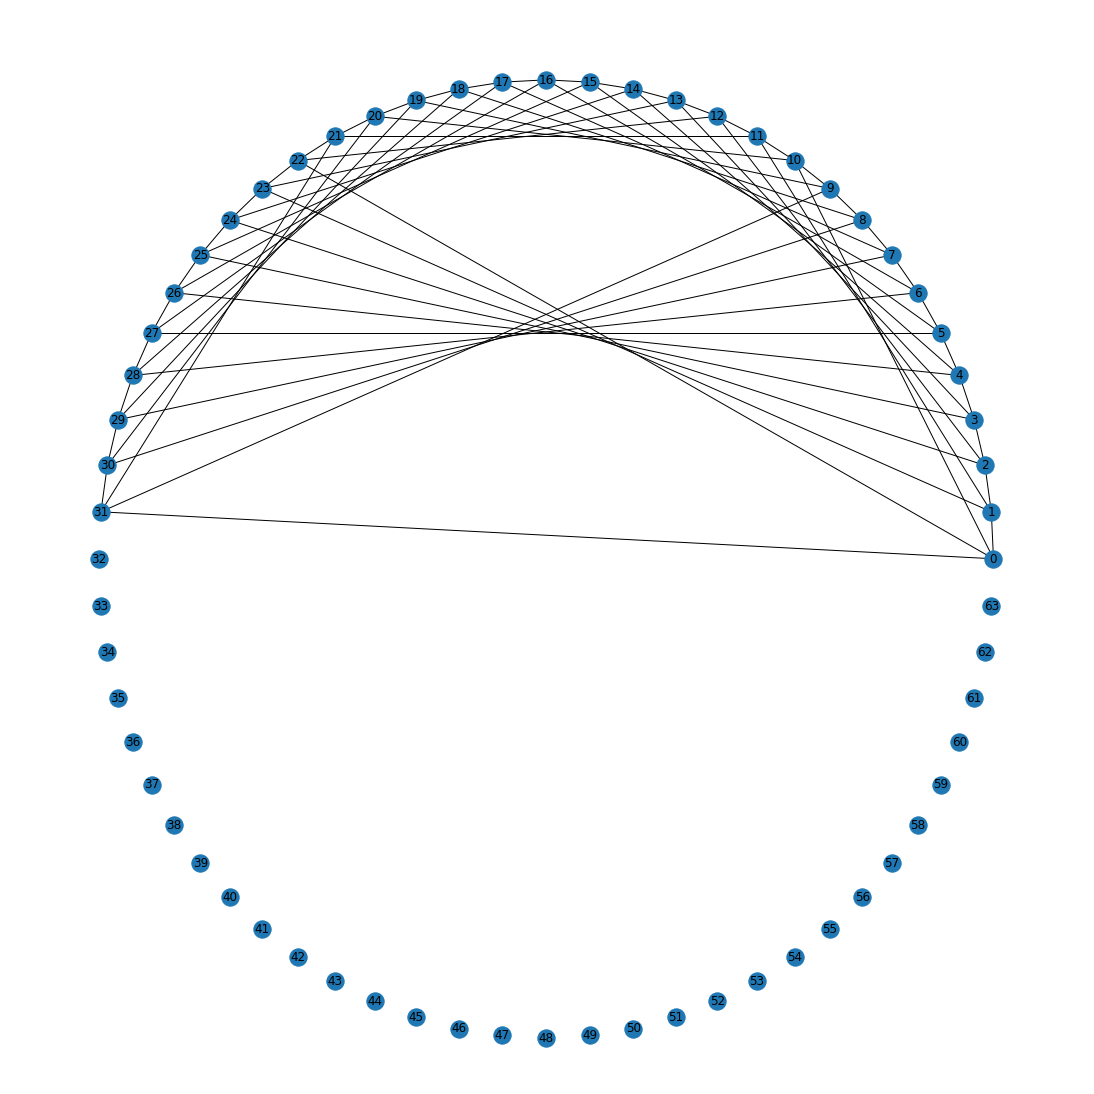

In [84]:
"""Generate any circulant graph"""
def circulant_graph(size, connections):
    rtn = nx.Graph()
    rtn.add_nodes_from(range(0,size))
    edges = []
    for distance in connections:
        edges += [(i,(i+distance)%size) for i in range(0,size)]
    rtn.add_edges_from(edges)
    return rtn

solution_space_G = circulant_graph(np.power(2, G.number_of_nodes()), [1,10])
plt.figure(3,figsize=(15,15)) 
nx.draw_circular(solution_space_G, with_labels=True)

In [ ]:
"""Get eigenvalues"""
data = np.linalg.eig(
    nx.adjacency_matrix(solution_space_G).todense()
)
eigenvalues = list(data[0])
print(eigenvalues)

In [85]:
"""Make diagonal operator and convert to circuit"""
def parameterized_lambda(time, eigenvalues):
    diagonalized_matrix = []
    for col in range(len(eigenvalues)):
        diagonalized_matrix.append([])
        for row in range(len(eigenvalues)):
            if row == col:
                diagonalized_matrix[-1].append(exp(1j * time * eigenvalues[row]))
            else:
                diagonalized_matrix[-1].append(0)
    return Operator(diagonalized_matrix)

In [86]:
"""Quality function for any graph"""
def quality(solution,graph):
    if len(solution) != graph.number_of_nodes():
        raise RuntimeError('Maxcut potential solution is not encoded correctly.')
    quality = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            quality += 1
    return quality


'''Computes average quality of all the bitstrings outputted by the circuit, accounting for multiplicity'''
def compute_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = quality(bitstring, graph)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

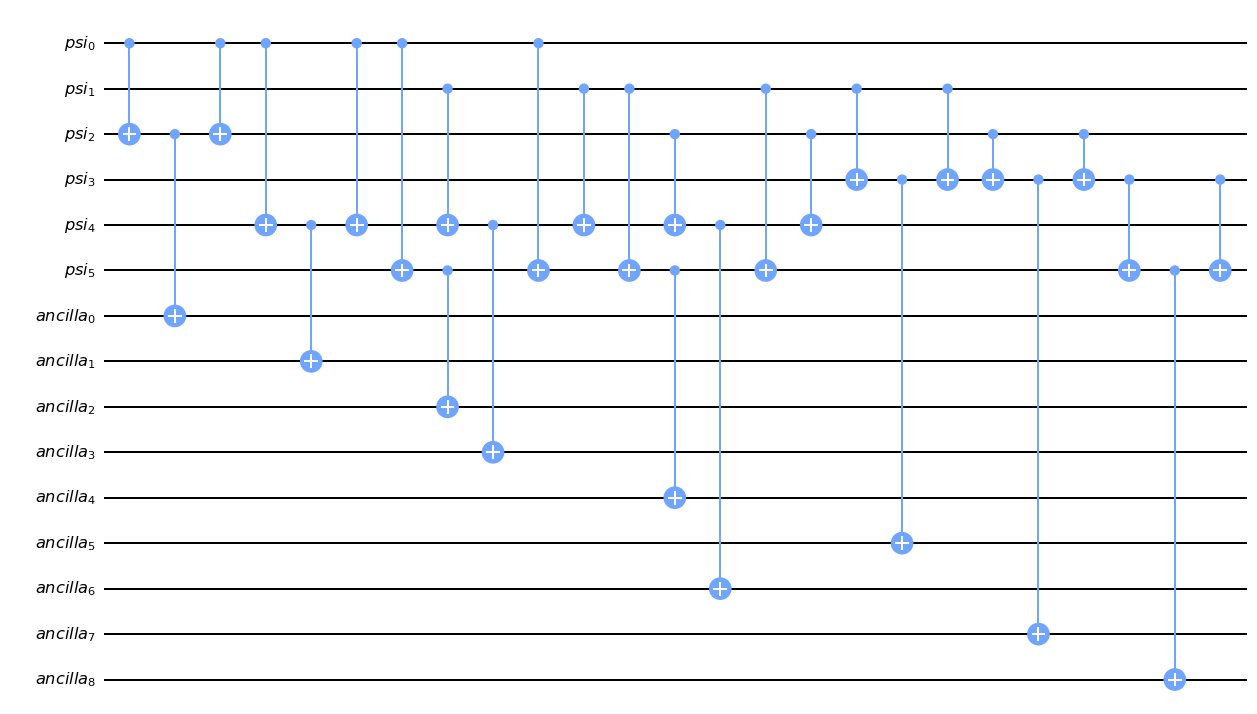

In [87]:
def quality_quantum_circuit(graph):
    problem_register = QuantumRegister(graph.number_of_nodes(), name='psi')
    ancilla_register = QuantumRegister(graph.number_of_edges(), name='ancilla')
    qc = QuantumCircuit(problem_register, ancilla_register, name = ' quality')
    for ancilla_index, (i, j) in enumerate(graph.edges()):
        qc.cx(i, j)
        qc.cx(j, ancilla_index + graph.number_of_nodes())
        qc.cx(i, j)
    return qc
quality_quantum_circuit(G).draw('mpl')

In [88]:
'''Create exp gates as shown in figure 1 of the paper'''
def exp_gate(i, gamma):
    return Operator(
        [[1, 0],
         [0, exp(-1j * (2**i) * gamma)]]
    )

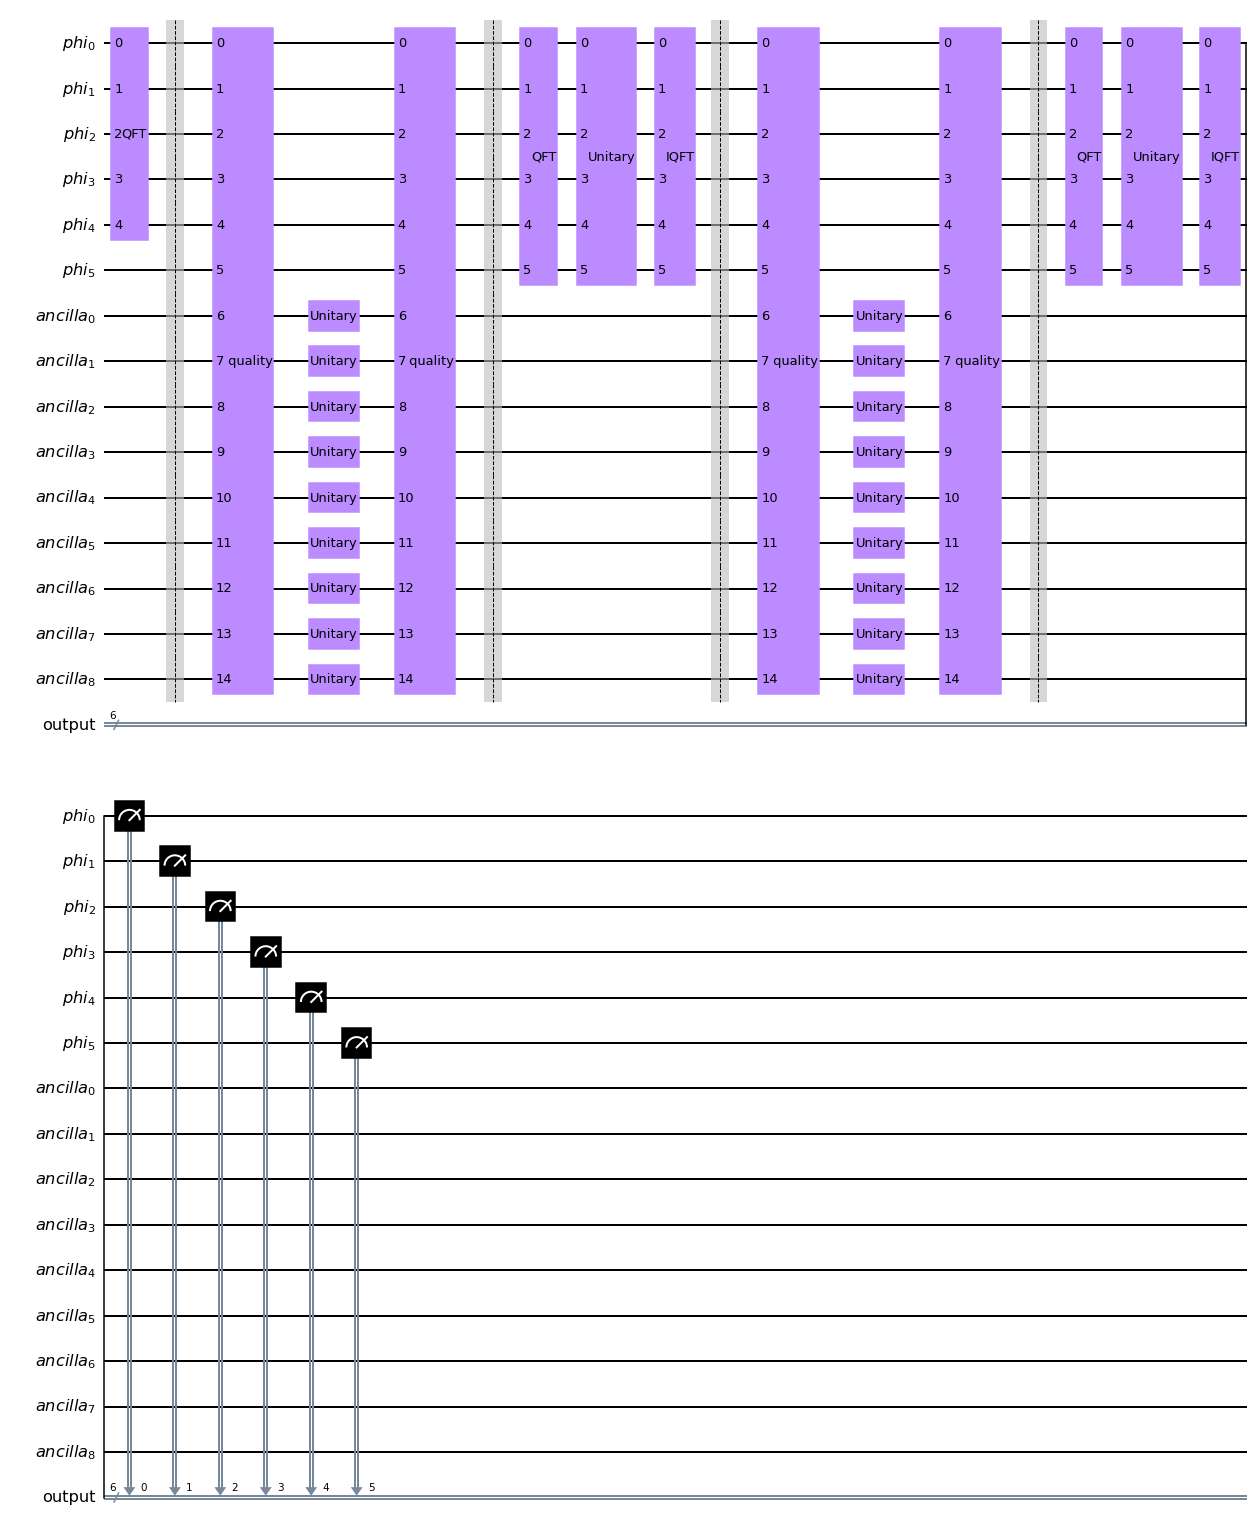

In [89]:
'''Create a depth 1 QWOA circuit based on input parameters'''
def create_circuit(params, G, eigenvalues):
    
    # extract parameters
    gamma = params[0]
    time = params[1]

    # define circuit
    problem_register = QuantumRegister(G.number_of_nodes(), name='phi')
    ancilla_register = QuantumRegister(G.number_of_edges(), name='ancilla')
    output_register = ClassicalRegister(G.number_of_nodes(), name='output')
    qc = QuantumCircuit(problem_register, ancilla_register, output_register)
    
    # initialize to a superposition over all valid states (in the case of maxcut, all states are valid)
    for i in range(0, G.number_of_nodes()):
        qc.h(i)

    qc.barrier()

    # compute quality
    quality_gate = quality_quantum_circuit(G).to_gate()
    qc.append(quality_gate, list(range(0, qc.num_qubits)))
    
    # apply gamma rotation to ancilla qubits
    for i in range(0,G.number_of_edges()):
        unitary = exp_gate(i, gamma)
        qc.append(unitary, [G.number_of_nodes()+i])
    
    # reapply quality gate
    qc.append(quality_gate, list(range(0, qc.num_qubits)))
    
    qc.barrier()
    
    #Set up fourier transform gates, look at operator matrix
    inv_qft_gate = QFT(G.number_of_nodes(), inverse=True).to_instruction()  
    qft_gate = QFT(G.number_of_nodes(), inverse=False).to_instruction()

    # quantum fourier transform on the solution phi
    qc.append(qft_gate, list(range(0, G.number_of_nodes())))
    
    lambda_gate = parameterized_lambda(time, eigenvalues)
    qc.append(lambda_gate, list(range(0, G.number_of_nodes())))

    qc.append(inv_qft_gate, list(range(0, G.number_of_nodes())))

    qc.measure(list(range(0, G.number_of_nodes())),list(range(0, G.number_of_nodes())))

    return qc
    
create_circuit([1, 1], G, eigenvalues).draw('mpl')


/tmp/ipykernel_16169/3067370528.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  eigenvalues[0] = np.linalg.eig(nx.adjacency_matrix(solution_space_G).todense())[0]
/tmp/ipykernel_16169/3067370528.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  eigenvalues[1] = np.linalg.eig(nx.adjacency_matrix(solution_space_G).todense())[0]
/tmp/ipykernel_16169/3067370528.py:17: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  eigenvalues[2] = np.linalg.eig(nx.adjacency_matrix(solution_space_G).todense())[0]
/tmp/ipykernel_16169/3067370528.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  eigenvalues[3] = np.linalg.eig(nx.adjacency_matrix(solution_space_G).todense())[0]
/tmp/ipykernel_16169/3067370528.py:24: FutureWarning: adjacency_matrix will return a scipy.spars

(7, [{0, 1, 2}, {0, 1, 3}, {0, 3, 4}])


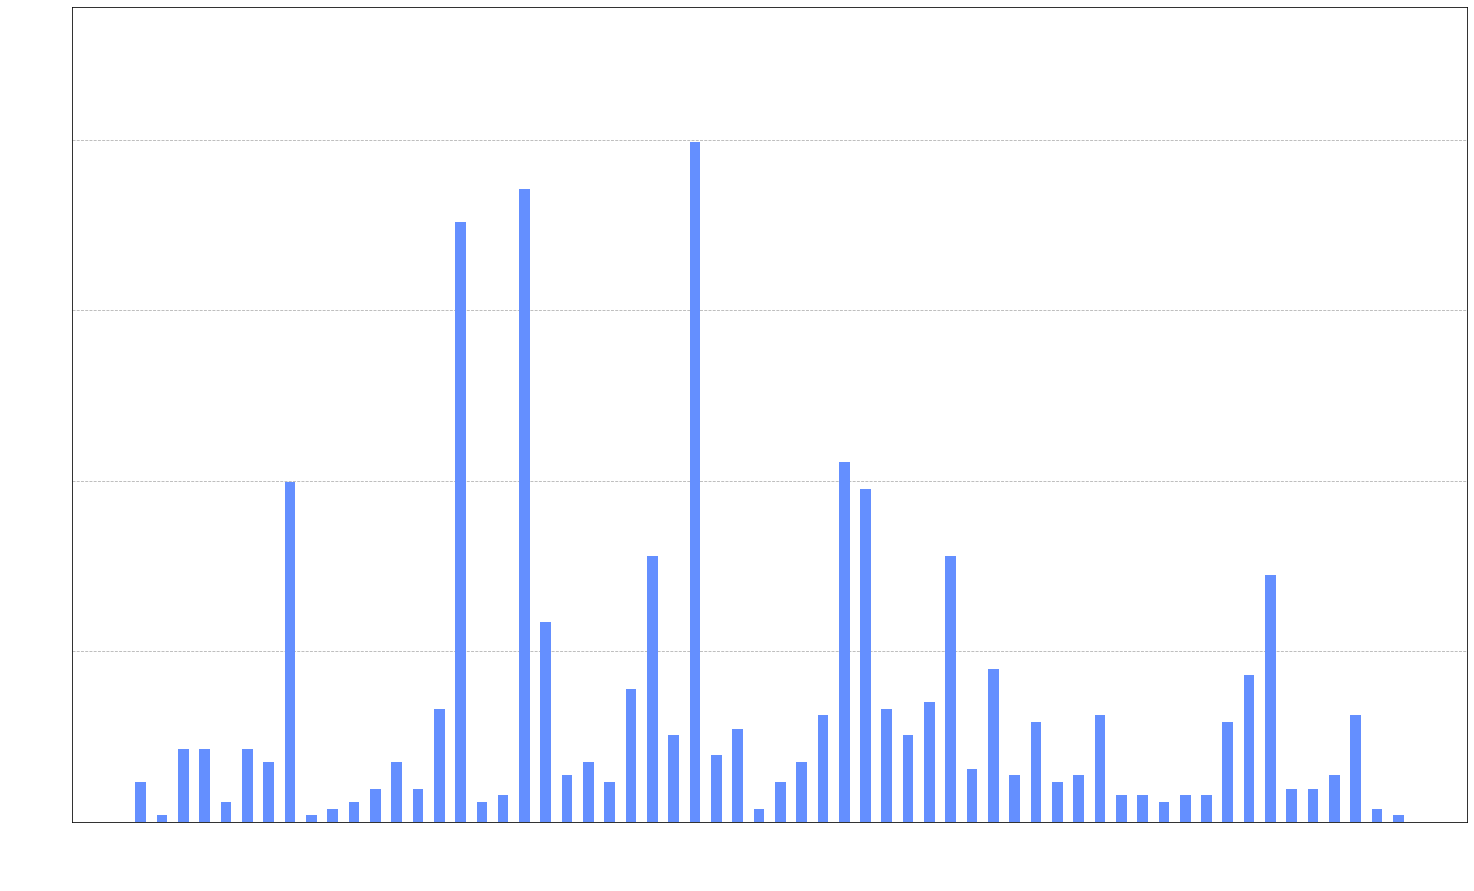

In [115]:
"""Simulate circuit and train parameters"""
backend = Aer.get_backend('qasm_simulator')
backend.shots = 512

def execute_circ(theta):
    qc = create_circuit(theta, G, eigenvalues)
    test = transpile(qc, backend)
    qobj = assemble(test)
    counts = backend.run(qobj, seed_simulator=10, nshots=512).result().get_counts()
    return -compute_expectation(counts, G)
    
res = minimize(execute_circ, [1.0, 1.0], method='COBYLA')

qc_res = create_circuit(res.x, G, eigenvalues)

test = transpile(qc_res, backend)
qobj = assemble(test)
counts = backend.run(qobj, seed_simulator=10).result().get_counts()

plot_histogram(counts,figsize=(25, 15))

In [11]:
def countour_plot (cost_function, resolution=32):
    grid_values = np.linspace(0, np.pi * 2, num=resolution)
    cost_values = np.zeros((resolution, resolution))
    row = column = 0
    for gamma in grid_values:
        for time in grid_values:
            cost_values[row][column] = cost_function([gamma, time])
            column += 1
        row += 1
        column = 0
    plt.figure(figsize=(15,15)) 
    plt.contourf(grid_values, grid_values, cost_values)
    plt.axis('scaled')
    plt.colorbar()
    plt.show()

/home/jeremy/Documents/Uni/2022/s1/comp2550/Assignment 3/ass3/comp2550-assignment-3/maxcut_qaoa.py:18: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()


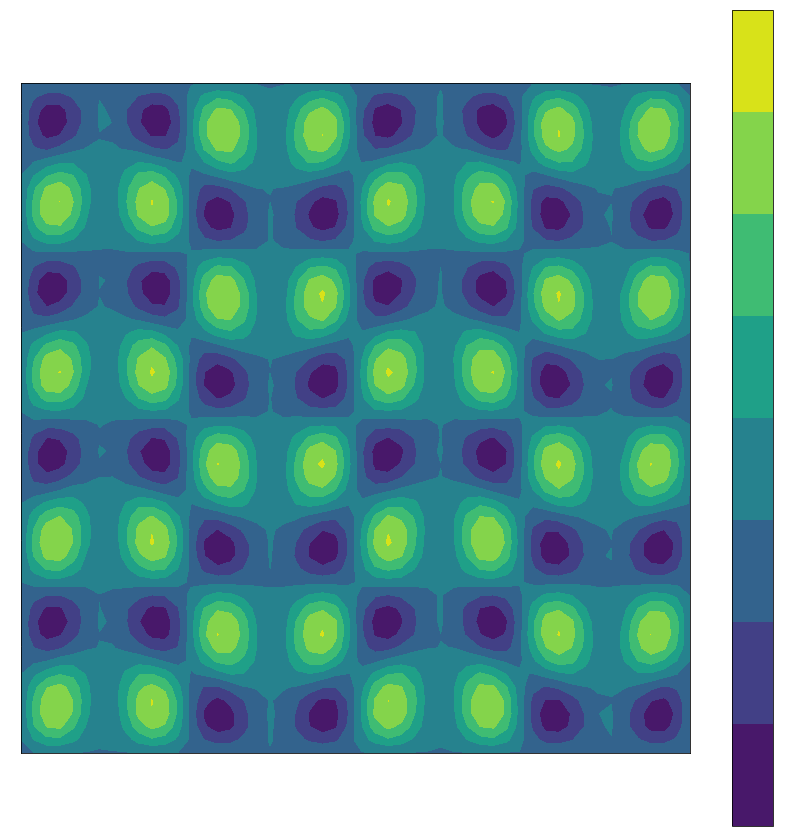

In [12]:
import maxcut_qaoa as qaoa
countour_plot(qaoa.get_expectation(G), 52)

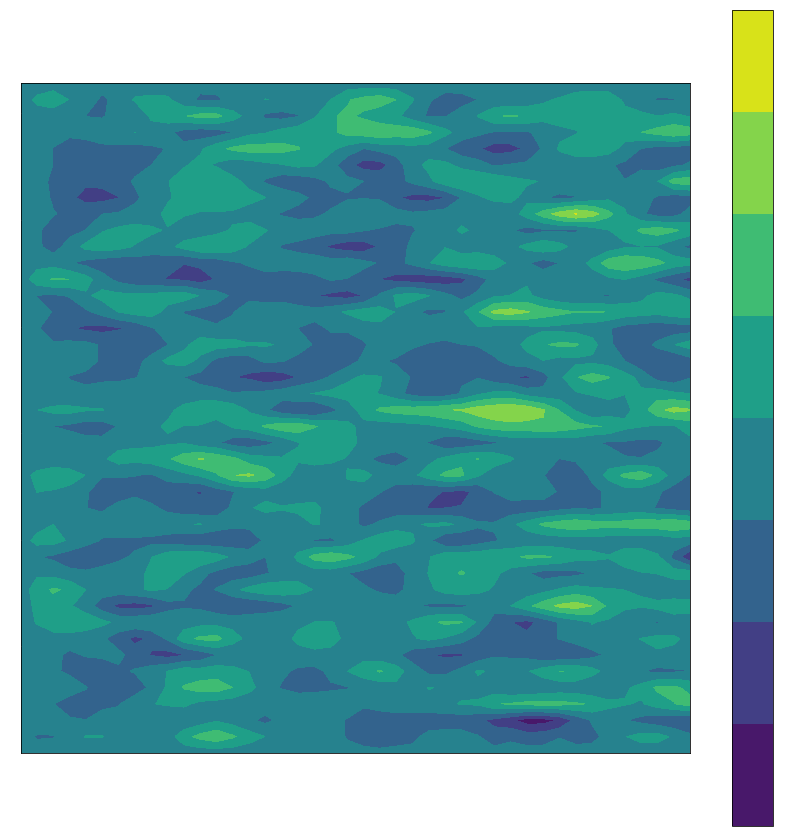

In [13]:
countour_plot(execute_circ, 42)

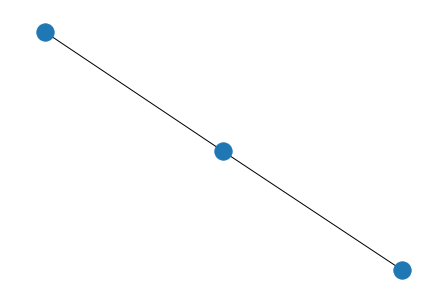

In [14]:
small_G = nx.Graph()
small_G.add_nodes_from([0,1,2])
small_G.add_edges_from([(0,1), (1,2)])
nx.draw(small_G)

/tmp/ipykernel_2942/1358791166.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  nx.adjacency_matrix(circulant_graph(8, [1,3])).todense()


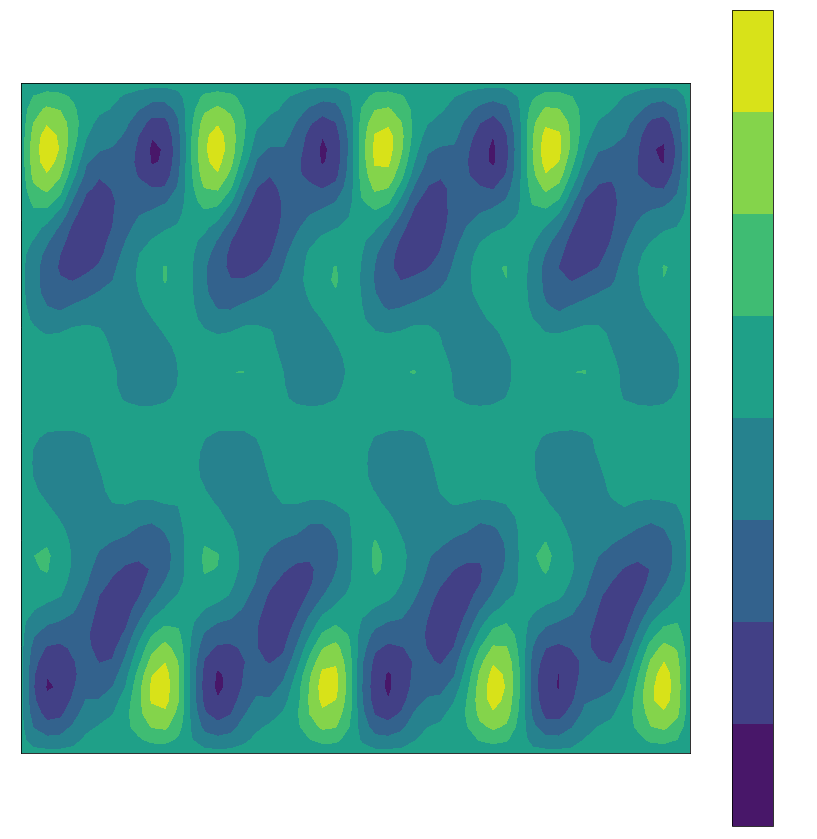

In [15]:
data = np.linalg.eig(
    nx.adjacency_matrix(circulant_graph(8, [1,3])).todense()
)
eigenvalues = list(data[0])

def execute_circ_small_graph(theta):
    qc = create_circuit(theta, small_G, eigenvalues)
    test = transpile(qc, backend)
    qobj = assemble(test)
    counts = backend.run(qobj, seed_simulator=10, nshots=512).result().get_counts()
    return -compute_expectation(counts, small_G)

countour_plot(execute_circ_small_graph, 52)